In [1]:
from yuning_util.dev_mode import DevMode
dev_mode = DevMode(pkg='k-seq')
dev_mode.on()
from importlib import reload
from k_seq.model import count
reload(count)
import numpy as np

# Tensorflow test model

In [4]:
import tensorflow_probability as tfp
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

tfd = tfp.distributions

In [99]:
# follow is an example from Jeff Pollock https://jeffpollock9.github.io/maximum-likelihood-estimation-with-tensorflow-probability-and-pystan/
# of fitting a Bernoulli distribution

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

# simulate the dataset

N = 1_000_000  # num_observation
P = 250 # parameter

tf.random.set_random_seed(23)

alpha = tfd.Normal(0.666, 1.0).sample() # alpha is a tensor with shape []
beta = tfd.Normal(0.0, 3.14).sample([P, 1]) # tensor with shape [250, 1], vertical vector

x = tfd.Normal(0.0, 1.0).sample([N, P]) # sampled tensor with shape [1_000_000, 250]
y = tfd.Bernoulli(alpha + x @ beta).sample()

# define the model

def loss(param, x, y):
    """Negative Log likelihood as loss, reduced on all observations"""
    alpha = param[0]
    beta = tf.expand_dims(param[1:], 1)
    model = tfd.Bernoulli(alpha + x @ beta)
    return -tf.reduce_sum(model.log_prob(y))

def loss_and_gradient(param, x, y):
    """pass a value and gradient object to tfp.optimizer.lbfgs_minimize,
    conditioned on the given data: (x, y)
    """
    return tfp.math.value_and_gradient(lambda param: loss(param, x, y),
                                       param)

def fit(x, y):
    """a fitting node to conduct fitting"""
    init = tf.zeros(tf.shape(x)[1] + 1)  # get the dimension of params
    opt = tfp.optimizer.lbfgs_minimize(
        lambda param: loss_and_gradient(param, x, y), init, max_iterations=1000
    )
    return opt

# run training
import time

with tf.Session() as sess:
    start = time.time()
    mle = fit(x, y)
    res = sess.run(mle)
    end = time.time()
    print(f"computation time: {end - start:.4f} seconds")
    
#     print(f"converged: {mle.}")
#     print(f"iterations: {mle.num_iterations}")

computation time: 17.1205 seconds


In [23]:
import tensorflow as tf

sess = tf.Session()

x = tf.constant([23, 1, 2,
                 0, 1, 2,
                 12, 12, 1])
y = tf.reshape(x, [3, -1])

with sess.as_default():
    print(y.eval())

[[23  1  2]
 [ 0  1  2]
 [12 12  1]]


# Tensorflow based count model

In [3]:
from k_seq.data.count_data import CountData

count_data = CountData.from_simu_path('/mnt/storage/projects/k-seq/datasets/simulated/')

In [81]:
tf.tile(tf.expand_dims([0, 2, 1], -1), [1, 5])

<tf.Tensor: id=25596, shape=(3, 5), dtype=int32, numpy=
array([[0, 0, 0, 0, 0],
       [2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1]], dtype=int32)>

In [4]:
import time
import tensorflow as tf
from k_seq.utility.log import Timer

tf.compat.v1.reset_default_graph()

with Timer():
    ctrl_var = count_data.ctrl_vars.loc['c'].astype(np.float32).values
    counts = count_data.count.to_numpy().astype(np.float32).T
    with tf.compat.v1.Session() as sess:
        pool_mask = ctrl_var > 0 # True for reacted sample, False for input sample
        # shape:
        #   ctrl_var [s]
        #   counts [s, m]
        #   pool_mask [s]
        mle_model = fit_count_model(ctrl_vars=ctrl_var, counts=counts, pool_mask=pool_mask, init_method='average')
        results = sess.run(mle_model)
        print(f'Convergence: {results.converged}')


Convergence: False
--------------------------------------------------
It took 4.71 minutes.


In [6]:
results

LBfgsOptimizerResults(converged=False, failed=True, num_iterations=2210, num_objective_evaluations=6647, position=array([-0.00737213,  1.9662449 ,  1.5344262 , ..., -0.09702338,
        0.09690278, -0.15281384], dtype=float32), objective_value=24549520.0, objective_gradient=array([ 0.55354404,  2.8157816 ,  2.116477  , ...,  0.02119913,
       -2.4748313 ,  1.460489  ], dtype=float32), position_deltas=array([[-1.5692785e-06, -8.1062317e-06, -5.7220459e-06, ...,
        -2.7567148e-07,  7.1898103e-06, -4.4107437e-06],
       [-1.5762635e-05, -8.8810921e-05, -6.2108040e-05, ...,
        -4.4181943e-06,  7.7158213e-05, -5.1915646e-05],
       [-2.0029489e-05, -1.1277199e-04, -7.8916550e-05, ...,
        -5.5581331e-06,  9.7997487e-05, -6.5907836e-05],
       ...,
       [ 9.1968104e-07,  5.6028366e-06,  3.8146973e-06, ...,
         3.6507845e-07, -4.7460198e-06,  3.3974648e-06],
       [ 1.1417083e-05,  6.5326691e-05,  4.5776367e-05, ...,
         3.4198165e-06, -5.6661665e-05,  3.8862228

In [8]:
def parse_param(results, index):
    import pandas as pd
    import numpy as np
    from scipy.special import softmax
    
    params = results.position
    params = np.reshape(params, [3, -1])
    theta = params[0]
    psi = params[1]
    phi = params[2]
    
    p0 = softmax(theta)
    k = np.exp(psi)
    a = np.exp(phi) / (1 + np.exp(phi))
    
    return pd.DataFrame({'p0': p0, 'k': k, 'a': a}, index=index)

In [9]:
from k_seq.utility.file_tools import read_pickle
results = read_pickle('/mnt/storage/projects/k-seq/working/count_model_mle/tf_lbfgs/on_doped_s1000_d40_t_12_crct_p_20/results.pkl')

In [10]:
results

LBfgsOptimizerResults(converged=True, failed=False, num_iterations=1275, num_objective_evaluations=3665, position=array([ 1.0653197 ,  1.7708325 ,  2.468448  , ..., -1.846058  ,
        0.77026165,  0.5441838 ], dtype=float32), objective_value=23503.773, objective_gradient=array([ 0.00070525,  0.00950931,  0.01054623, ...,  0.0426274 ,
       -0.01856064, -0.04493409], dtype=float32), position_deltas=array([[-2.1934509e-05, -9.7036362e-05,  1.7595291e-04, ...,
        -1.6391277e-04,  2.9802322e-07,  1.2105703e-04],
       [-3.4570694e-06, -3.1590462e-05,  8.3446503e-05, ...,
         4.8279762e-05, -4.8875809e-06, -2.0027161e-05],
       [-1.7642975e-05, -8.9168549e-05,  1.9168854e-04, ...,
         3.6716461e-05, -6.3776970e-06, -1.5497208e-06],
       ...,
       [ 3.0398369e-05, -4.5537949e-05,  6.6041946e-05, ...,
        -2.3686886e-04,  2.5153160e-05,  2.0015240e-04],
       [-7.1525574e-07, -3.1948090e-05,  2.9802322e-05, ...,
        -7.7605247e-05,  2.3126602e-05,  7.4625015e

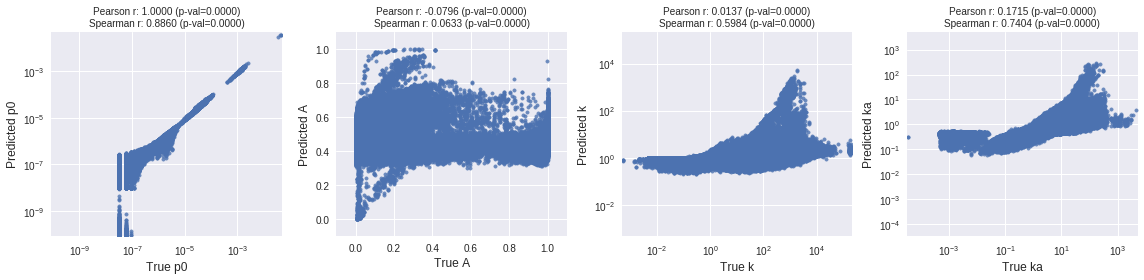

In [9]:
params = parse_param(results, index=count_data.count.index.values)

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')

fig, axes = plt.subplots(1, 4, figsize=[16, 4])

def align_plot(x_data, y_data, ax, ax_log=True, label='value'):
    ax.scatter(x_data, y_data, marker='.', alpha=0.8)
    if ax_log:
        lim = (min(x_data.min(), y_data.min()) * 0.9, max(x_data.max(), y_data.max()) * 1.1)
    else:
        pad = max(x_data.max(), y_data.max()) * 0.1
        lim = (min(x_data.min(), y_data.min()) - pad, max(x_data.max(), y_data.max()) + pad)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    if ax_log:
        ax.set_xscale('log')
        ax.set_yscale('log')
    from scipy.stats import pearsonr, spearmanr
    pearson = pearsonr(x=x_data, y=y_data)
    spearman = spearmanr(a=x_data, b=y_data)
    ax.set_title(f"Pearson r: {pearson[0]:.4f} (p-val={pearson[1]:.4f})\n"
                 f"Spearman r: {spearman.correlation:.4f} (p-val={spearman.pvalue:.4f})", fontsize=10)
    ax.set_xlabel(f'True {label}', fontsize=12)
    ax.set_ylabel(f'Predicted {label}', fontsize=12)
    

align_plot(count_data.truth.p0, params.p0, ax=axes[0], ax_log=True, label='p0')
align_plot(count_data.truth.A, params.a, ax=axes[1], ax_log=False, label='A')
align_plot(count_data.truth.k, params.k, ax=axes[2], ax_log=True, label='k')
align_plot(count_data.truth.k * count_data.truth.A, params.k * params.a, ax=axes[3], ax_log=True, label='ka')

plt.tight_layout()
plt.show()

In [66]:
from scipy.stats import pearsonr, spearmanr
        ax.set_title(f"Pearson: {stats.pearsonr(x, y)[0]:.4f}\n\tp]{}Spearman: {stats.spearmanr(x, y)[0]:.4f}")


0.0009036517454963842

## On BYO-doped pool

In [3]:
from k_seq.data import seq_table
byo_doped = seq_table.SeqTable.load_default_dataset(dataset='byo_doped')

Load BYO-doped pool data from pickled record at /mnt/storage/projects/k-seq/datasets/byo_doped.pkl
Imported!


In [4]:
byo_doped.filtered_table

,A1,A2,A3,B1,B2,B3,C1,C2,C3,D1,D2,D3,E1,E2,E3,R0
CTACTTCAAACAATCGGTCTG,2073359,2223890,4673972,2375053,2925890,2602711,1509853,2060371,2188132,1894508,2005826,1712433,768138,1903080,1535263,1452168
CCACACTTCAAGCAATCGGTC,1918612,2063146,4473364,2005514,2398999,2190556,1125797,1509769,1555068,1362890,1470216,1155490,529124,1337152,1026848,1246770
ATTACCCTGGTCATCGAGTGA,1231995,1116392,2439960,1476384,1534694,1481682,2217682,1945364,2359447,3419619,3071206,3270499,1822663,4514332,4338722,1114058
AAGTTTGCTAATAGTCGCAAG,989320,852125,1917147,1065499,976044,901923,626570,582849,718972,746781,554123,516678,311240,420069,430141,1421715
GTACTTCAAACAATCGGTCTG,98231,93653,199970,99669,114584,100818,58189,75606,77390,71419,70333,55207,27347,59957,47546,85808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACACGCCACACGCAATCGGTC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
AACTCTGCGAATAATCGCAAG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
ATTACTATGGTCGTCGAGTGC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
ATTGCCTTGGTCATCGACAGA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


In [11]:
var = np.array(list(np.array([2, 10, 50, 250, 1250]) * 1e-6) * 3 + [-1], dtype=np.float32)
counts = byo_doped.filtered_table.to_numpy().T.astype(np.float32)

In [37]:
import time
import tensorflow as tf

tf.compat.v1.reset_default_graph()

with tf.compat.v1.Session() as sess:
    start = time.time()
    print(var)
    sample_mask = np.array([c > 0 for c in var])
    print(sample_mask)
    mle = fit_count_model(var=var, count=counts, sample_mask=sample_mask, init_method='average')
    res = sess.run(mle)
    end = time.time()
    print(f"computation time: {end - start:.4f} seconds")
    assert res.converged

[ 2.00e-06  1.00e-05  5.00e-05  2.50e-04  1.25e-03  2.00e-06  1.00e-05
  5.00e-05  2.50e-04  1.25e-03  2.00e-06  1.00e-05  5.00e-05  2.50e-04
  1.25e-03 -1.00e+00]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False]
computation time: 138.2386 seconds


AssertionError: 

In [38]:
params = parse_param(res.position)

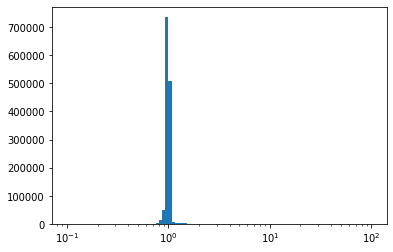

In [44]:
bins = np.logspace(-1, 2, 100)
plt.hist(params.k, bins=bins)
plt.xscale('log')
plt.show()

In [40]:
params.k

array([19.420952  , 24.393702  , 13.759039  , ...,  0.99073625,
        0.99073625,  0.99073625], dtype=float32)

# Pool Simulator

In [12]:
from k_seq.data import CountFileSet

bfo_data = CountFileSet.load_default(dataset='bfo')
bfo_data.load_data()

array([[     1],
       [     1],
       [     1],
       ...,
       [ 28860],
       [122377],
       [605843]])

In [59]:
from k_seq.model import pool, count, kinetic
from k_seq.data import simu
import pandas as pd
reload(pool)
reload(count)
reload(kinetic)
reload(simu)

# summarize following into a function

p0 = simu.pSampler(n=1e5).from_list(seqs['A-inputA'])
A = simu.ASampler(n=1e5).from_uniform(low=0, high=1)
k = simu.kSampler(n=1e5).from_lognormal(c95=[0.5, 50])
ribo_info = pd.DataFrame({'p0': p0, })

In [ ]:
p0 = simu.pSampler.from_list()

In [60]:
k

array([ 2.11322467, 54.20552086,  0.74818859, ...,  2.02509913,
       40.57007239, 16.27110082])